# Document Classification On Imbalanced Data
------------------

## Table of Contents

__[1. Introduction](#first-bullet)__

__[2. The Dataset: Creating, Storing and Exploring](#second-bullet)__

__[3. TF-IDF: Preprocessing & Feature Extraction](#third-bullet)__

__[4. The Naive Bayes Model](#fourth-bullet)__

__[5. Imablanced Learn: Fixing Imbalanced Data](#fifth-bullet)__

__[6. NLTK: Stop Words & Lemmatization](#seventh-bullet)__

__[8. HyperParameter Tunning With GridSearchCV](#eigth-bullet)__

__[9. Conclusions](#ninth-bullet)__


---------

## Introduction <a class="anchor" id="first-bullet"></a>
-----------

Natural language processing or NLP is an hot topic in data science and machine learning.  While research in NLP dates back to the 1950's, the real revolution in this domain came in 1980's and 1990's with the introduction of statistical models and fast computational power. Before this most language processing tasks made use of hand-coded rules which were generally not very robust.

The span of topics in Natural Language Processing is immense and I'll just getting to the tip of the iceberg with going over the topic of [document classification](https://en.wikipedia.org/wiki/Document_classification) also known as [text classification](https://monkeylearn.com/text-classification/).  I will be working with the <a href="http://scikit-learn.org/">Scikit-learn</a> library and using an imbalanced dataset that I create from summaries of papers published on (arxiv)[https://arxiv.org]. The topic of each paper is given a classification alleviating the need to label the dataset.  I create an imbalance in the number of topics I train on as having imbalanced makes the developing a good model more challenging, but it is also more realistic.  Imbalanced classes often occur in classification problems and many times it is too expensive or not possible to get more data on the classes that have to few samples. Developing strategies for dealing with imbalanced data is paramount for creating good classification models.

Let's dive into the data! 

## The Dataset: Creating, Storing and Exploring<a class="anchor" id="second-bullet"></a>

The first thing I want to do is create a database to store the data between session on this project. I chose to create a local [MongoDB](https://www.mongodb.com/) database since its easy to use and I have [experience](https://api.mongodb.com/python/current/) with it and [PyMongo](https://api.mongodb.com/python/current/). 

We can create a client with pymongo and create a new database using the commands: 

In [4]:
import pymongo
conn = pymongo.MongoClient('mongodb://localhost:27017')
db   = conn.db_arxiv

Now that we have to actually collect the data.  We will use the Python library [arxiv](https://github.com/lukasschwab/arxiv.py) to allow us to collect data from the [arxiv api](https://arxiv.org/help/api):

In [5]:
import arxiv

We will focus on only four topics in this blogpost and those are:
    
* Artificial Intelligence
* Numerical Analysis
* Material Science
* Programming Languages
    
These topics are pretty different and therefore I expect there to be significant differences in the words in the summaries of the topics in the papers. This means I will expect pretty good performance of our model.

We query the the arxiv api and create a list of dictionaries for each topic.  The dictionary will include the 

1. The link to the paper
2. The category code arxiv gave for this papers topic
3. The label for this category
4. The text of the summary for this paper.

Let's collect 1000 articles on artificial intelligence, numerical analysis and material science as well as 300 topics on programming languages:

In [6]:
# artificial intelligence
ai_results = [{'link'     : doc['id'],
               'code'     : doc['arxiv_primary_category']['term'],
               'category' : 'artifical_intelligence',
               'text'     : doc['summary']}
             for doc in arxiv.query(query='cat:cs.AI', max_results=1000)]

# numerical analysis
na_results = [{'link'     : doc['id'],
               'code'     : doc['arxiv_primary_category']['term'],
               'category' : 'numerical_analysis',
               'text'     : doc['summary']}
              for doc in arxiv.query(query='cat:math.NA', max_results=1000)]

# material science
mat_results = [{'link'     : doc['id'],
                'category' : 'material_science',
                'code'     : doc['arxiv_primary_category']['term'],
                'text'     : doc['summary']}
              for doc in arxiv.query(query='cat:cond-mat.mtrl-sci', max_results=1000)]

# progamming languages
prog_results = [{'link'     : doc['id'],
                 'category' : 'programming_languages',
                 'code'     : doc['arxiv_primary_category']['term'],
                 'text'  : doc['summary']}
              for doc in arxiv.query(query='cat:cs.PL', max_results=300)]

We can look at some the results:

In [7]:
mat_results[1]

{'link': 'http://arxiv.org/abs/cond-mat/9312041v1',
 'category': 'material_science',
 'code': 'cond-mat.mtrl-sci',
 'text': "The recursion and path-integral methods are applied to analytically study the\nelectronic structure of a neutral $C_{60}$ molecule. We employ a tight-binding\nHamiltonian which considers both the $s$ and $p$ valence electrons of carbon.\nFrom the recursion method, we obtain closed-form {\\it analytic} expressions for\nthe $\\pi$ and $\\sigma$ eigenvalues and eigenfunctions, including the highest\noccupied molecular orbital (HOMO) and the lowest unoccupied molecular orbital\n(LUMO) states, and the Green's functions. We also present the local densities\nof states around several ring clusters, which can be probed experimentally by\nusing, for instance, a scanning tunneling microscope. {}From a path-integral\nmethod, identical results for the energy spectrum are also derived. In\naddition, the local density of states on one carbon atom is obtained; from this\nwe can 

We can see that there is some [LaTeX](https://www.latex-project.org/about/) sprinkled in the summary text that we may have to address in data cleaning.

### Storing The Train and Test Set

The four topics we are trying to predict are also called the target classess or classes. We refer to artifical intelligence, numerical analysis and material science as the "majority classes" and programming languages as the "minority class" due to the discrepencies in the number of datapoints.  Let's break out data set into a 75% training and 25% testing.  We create the training set:

In [8]:
maj_train = 750
min_train = 225

train = ai_results[0:maj_train]  + na_results[0:maj_train] +\
        mat_results[0:maj_train] + prog_results[0:min_train]

And then insert them into the MongoDB databases as the `training collection`:

In [14]:
# insert them into training collection
db.train_papers.insert_many(train, ordered=False)

We then do the same for the test set:

In [15]:
test = ai_results[maj_train-1 :-1] + na_results[maj_train-1:-1] +\
       mat_results[maj_train-1:-1] + prog_results[min_train-1:-1]

# insert them into training collection
db.test_papers.insert_many(test, ordered=False)

Now that we have stored the datasets, let's read them back and connvert them to a Pandas dataframe:

In [16]:
import pandas as pd

# projection for subselecting only `text` and `category` fields
project = {"_id":0,"text":1,"category":1}

# get the training set
train_df = pd.DataFrame(db.train_papers.find({},project))

# get the testing set
test_df = pd.DataFrame(db.test_papers.find({},project))

Let's take a look what the dataframes look like:

In [17]:
train_df.head()

,category,text
0,artifical_intelligence,Because of their occasional need to return to ...
1,artifical_intelligence,Market price systems constitute a well-underst...
2,artifical_intelligence,We describe an extensive study of search in GS...
3,artifical_intelligence,As real logic programmers normally use cut (!)...
4,artifical_intelligence,To support the goal of allowing users to recor...


We can see the number of samples we have in each dataframe:

In [18]:
train_df.shape[0] + test_df.shape[0] 

3300

In order for our model to predict the topic of each summary we need to convert the category into a number.  For that we use the [Scikit-Learn LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class.  We append a new column to the dataframe called `target` that will be the numerical value of the class:

In [19]:
from sklearn.preprocessing import LabelEncoder  

labeler = LabelEncoder()
train_df["target"] = labeler.fit_transform(train_df["category"])
test_df["target"]  = labeler.transform(test_df["category"])

In order to view the human readible version of the target we create a dictionary to map the categorical variables (numbers) to labels:

In [20]:
mapping = dict(zip(labeler.classes_, range(len(labeler.classes_))))
print(mapping)

{'artifical_intelligence': 0, 'material_science': 1, 'numerical_analysis': 2, 'programming_languages': 3}


Let's take a look at the number of samples in the training and test set:

In [61]:
train_cts = train_df.groupby("target").size()
test_cts  = test_df.groupby("target").size()

Text(0, 0.5, 'Counts')

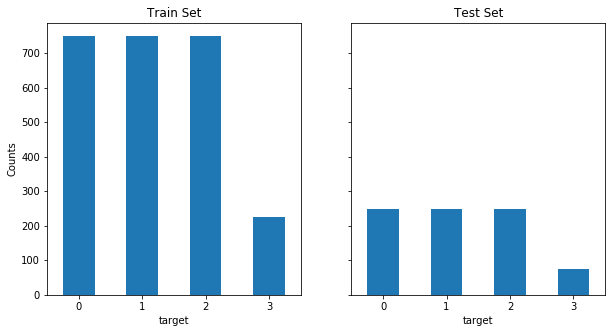

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
train_cts.plot(kind='bar',ax= ax1,rot=0)
test_cts.plot(kind='bar',ax= ax2,rot=0)
ax1.set_title('Train Set')
ax2.set_title('Test Set')
ax1.set_ylabel("Counts")

In terms of percentages they are the exact same percentage of target classes: 

Text(0, 0.5, '%')

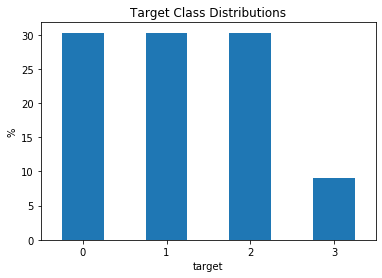

In [84]:
percents = 100 * train_df.groupby("target").size() / train_df.shape[0]

percents.plot(kind='bar', title='Target Class Distributions', rot=0)
plt.ylabel("%")
              

We can look an example article summary and its target value:

In [25]:
print("Category:\n{}\n".format(train_df["category"][5]))
print("Target: {}\n".format(train_df["target"][5]))
print("Text:\n", train_df["text"][5])

Category:
artifical_intelligence

Target: 0

Text:
 Terminological knowledge representation systems (TKRSs) are tools for
designing and using knowledge bases that make use of terminological languages
(or concept languages). We analyze from a theoretical point of view a TKRS
whose capabilities go beyond the ones of presently available TKRSs. The new
features studied, often required in practical applications, can be summarized
in three main points. First, we consider a highly expressive terminological
language, called ALCNR, including general complements of concepts, number
restrictions and role conjunction. Second, we allow to express inclusion
statements between general concepts, and terminological cycles as a particular
case. Third, we prove the decidability of a number of desirable TKRS-deduction
services (like satisfiability, subsumption and instance checking) through a
sound, complete and terminating calculus for reasoning in ALCNR-knowledge
bases. Our calculus extends the general 

Now lets take a look a the most commonly used words in each target class using a [word cloud](https://amueller.github.io/word_cloud/)

In [26]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(df: pd.DataFrame, category: str, target: int)-> None:
    words = " ".join(train_df[train_df["target"] == target]["text"].values)

    plt.rcParams['figure.figsize'] = 10, 20
    wordcloud = WordCloud(stopwords=STOPWORDS, 
                          background_color="white",
                          max_words=1000).generate(words)

    plt.title("WordCloud For {}".format(category))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    

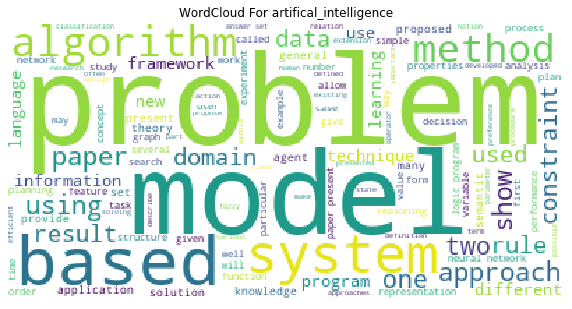

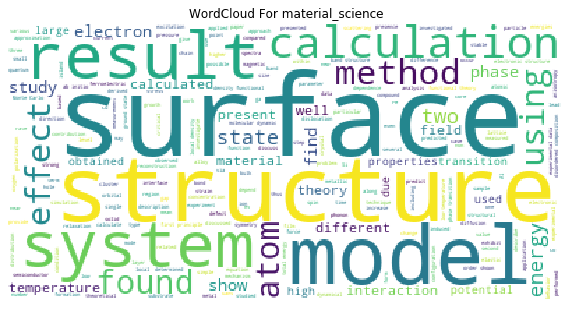

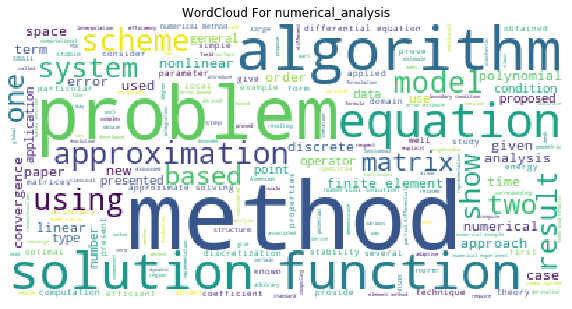

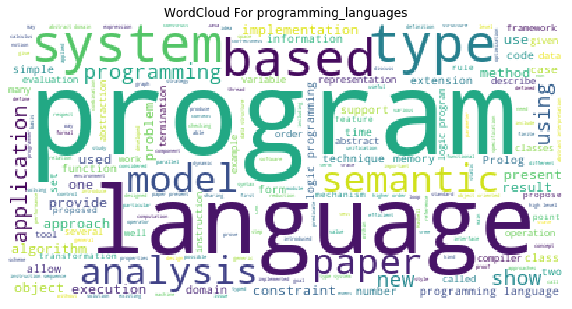

In [27]:
for category, target in mapping.items():
    plot_wordcloud(train_df, category, target)

We can see that some of the most common words to each topic (i.e. "problem", "model") are commonly occuring across topics. If we run into issues with our model performance we may consider including these common words as stop words.


Now that we have an idea of what kind of data we are working with we can start to do some machine learning on it.  As with all datasets there is some required preprocessing before machine learning.  With numerical data there needs to be some cleaning and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html">scaling</a> of the features. However, in Natural Language Processing there is much more substantial preprocessing stage that we'll go over next.

##  TF-IDF: Preprocessing & Feature Extraction <a class="anchor" id="third-bullet"></a>
--------------------

The first thing we need to go over is the concept of the <a href="https://en.wikipedia.org/wiki/Bag-of-words_model">**bag of words model**</a>.  *In the bag-of-words model, a text (such as a sentence or a document) is represented as "bag" or list of its words, disregarding grammar and even word order, but keeping multiplicity of the words.*  A two document example is:

- **D1:**  Hi, I am Mike and I like Boston.

- **D2:**  Boston is a city and people in Boston like the Red Sox.

From these two documents, a list, or 'bag-of-words' is constructed

    bag = ['Hi', 'I', 'am', 'Mike', 'and', 'like', 'Boston', 'is', 
           'a', 'city, 'and', 'people', 'in', 'the', 'red', 'sox]


Notice how in our bag-of-words we have dropped repetitions of the words 'I', 'is' and 'Mike', we will show how multiplicity of words enters into our model next. 

The bag-of-words model is mainly used as a tool of feature generation. After transforming the text into a "bag of words", we can calculate various measures to characterize the document.  In order to do so we have to generate a vector for each document that represents the number of times each entry in the bag of words appears in the text. The order of entries in the vector corresponds to the order of the entries in the bag-of-words list.  For example, document D1 would have a vector,

    [1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0 ,0, 0, 0, 0, 0]
    
while the second document, D2, would have the vector,

    [0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]

Each entry of the lists refers to frequency or count of the corresponding entry in the bag-of-words list.  When we have a stacked collection of (row) vectors, or matrix, where each row corresponds to a document (vector), and each column corresponds to a word in the bag-of-words list, then this will be known as our **term-frequency ($\text{tf}$) [document matrix](https://en.wikipedia.org/wiki/Document-term_matrix)**. The general formula for an entry in the $\text{tf}$ matrix is,

$$\text{tf}(d,t) \,  = \, f_{t,d}$$
    
where $f_{t,d}$ is the number of times the term $t$ occurs in document $d \in \mathcal{D}$, where $\mathcal{D}$ is our text corpus. We can create a term-frequency matrix for the above example using Scikit-learns <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer">CountVectorizer</a> class:

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer =  CountVectorizer()

corpus     = ["Hi, I am Mike and I like Boston.",
              "Boston is a city and people in Boston like the Red Sox."]

# get the term frequency
tf  = vectorizer.fit_transform(corpus)

# get the words in bag-of-words
print(vectorizer.get_feature_names())

# get the counts!
print(tf.toarray())

['am', 'and', 'boston', 'city', 'hi', 'in', 'is', 'like', 'mike', 'people', 'red', 'sox', 'the']
[[1 1 1 0 1 0 0 1 1 0 0 0 0]
 [0 1 2 1 0 1 1 1 0 1 1 1 1]]


The order of the words is off and CountVectorizer dropped single letter words and punctutation, but the rest is the same!

**Notice CountVectorizer converts everything to lowercase, drops single letter words and punctuation.**

Let's try CountVectorizer on our dataset:

In [29]:
count_vect = CountVectorizer()

X_train_tf = count_vect.fit_transform(train_df["text"])

print("Shape of term-frequency matrix:", X_train_tf.shape)

Shape of term-frequency matrix: (2475, 14511)


The term-frequency is a sparse matrix where each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list. This can be confirmed by comparing the number of rows in the term-frequency matrix to the number of documents in the training set:

In [30]:
print("Number of training documents: ", train_df.shape[0])

Number of training documents:  2475


Most often term-frequency alone is not a good measure of the importance of a word/term to a document's topic.  Very common words like "the", "a", "to" are almost always the terms with the highest frequency in the text. Thus, having a high raw count of the number of times a term appears in a document does not necessarily mean that the corresponding word is more important. Furtermore, longer documents could have high frequency of terms that do not correlate with the document topic, but instead occur with high numbers solely due to the length of the document.

To circumvent the limination of term-frequency, we often normalize it by the **inverse document frequency (idf)**.  This results in the **term frequency-inverse document frequency (tf-idf)** matrix.  The *inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents in the corpus*.  We can give a formal defintion of the inverse-document-frequency by letting $\mathcal{D}$ be the corpus or the set of all documents and $N$ is the number of documents in the corpus and $N_{t,D}$ be the number of documents that contain the term $t$ then, 

$$idf(t,\mathcal{D}) \, = \,  \log\left(\frac{N_{\mathcal{D}}}{1 + N_{t,\mathcal{D}}}\right) \, = \, -  \log\left(\frac{1 + N_{t,\mathcal{D}}}{N_{\mathcal{D}}}\right) $$

The reason for the presence of the $1$ is for smoothing.  Without it, if the term/word did not appear in any training documents, then its inverse-document-frequency would be $idf(t,\mathcal{D}) = \infty$.  However, with the presense of the $1$ it will now have $idf(t,\mathcal{D}) = 0$.


Now we can formally defined the term frequnecy-inverse document frequency as a normalized version of term-frequency,


$$\text{tf-idf}(t,d) \, = \, tf(t,d) \cdot idf(t,\mathcal{D}) $$

Like the term-frequency, the term frequency-inverse document frequency is a sparse matrix, where again, each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list.  The $\text{tf-idf}$ matrix can be constructed using the sklearn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html">TfidfTransformer</a> class:

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_train_tfidf.shape

(2475, 14511)

We should note that the $\text{tf-idf}$ matrix is the same shape as the $\text{tf}$ matrix, but the two have different values.


Now that we have built our $\text{tf-idf}$ matrix we can start to look at the which terms/words are most associated with document topics and then build a predictive model to classify the documents' topic. Let's first go over the model we will be using for prediction.

## The Naive Bayes Model <a class="anchor" id="fourth-bullet"></a>
-------------------

One of the most basic models for text classification is the <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier">Naive Bayes model</a>. The Naive Bayes classification model predicts the document topic, $y = \{C_{1},C_{2},\ldots, C_{k}\}$ where $C_{k}$ is the class or topic based on the document feactures $\textbf{x} \in \mathbb{N}^{p}$,  and $p$ is the number of terms in our bag-of-words list.  The feature vector,

$$\textbf{x} \, = \, \left[ x_{1}, x_{2}, \ldots , x_{p} \right] $$

contains counts $x_{i}$ for the $\text{tf-idf}$ value of the i-th term in our bag-of-words list.  Using <a href="https://en.wikipedia.org/wiki/Bayes%27_theorem">Bayes Theorem</a> we can develop a model to predict the topic class  ($C_{k}$) of a document from its feature vector $\textbf{x}$,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right)P(C_{k})}{P\left(x_{1}, \ldots, x_{p} \right)}$$

The Naive Bayes model makes the "Naive" assumption the probability of each term's $\text{tf-idf}$ is **conditionally independent** of every other term.  This reduces our **conditional probability function** to the product,

$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \; = \; \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$

Subsequently Bayes' theorem for our classification problem becomes,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{ P(C_{k}) \, \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)}{P\left(x_{1}, \ldots, x_{p} \right)}$$


Since the denominator is independent of the class ($C_{k}$) we can use a <a href="https://en.wikipedia.org/wiki/Maximum_a_posteriori">Maxmimum A Posteriori</a> method to estimate the document topic , 

$$ \hat{y} \, = \, \text{arg max}_{k}\;  P(C_{k}) \,  \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$ 


The **prior**, $P(C_{k}),$ is often taken to be the relative frequency of the class in the training corpus, while the form of the conditional distribution $P\left(x_{i} \, \vert \, C_{k} \right)$ is a choice of the modeler and determines the type of Naive Bayes classifier. 


We will use a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB">multinomial Naive Bayes</a> model which works well when our features are discrete variables such as those in our $\text{tf-idf}$ matrix.  In the multinomial Naive Bayes model the conditional probability takes the form,


$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \, = \, \frac{\left(\sum_{i=1}^{p} x_{i}\right)!}{\Pi_{i=1}^{p} x_{i}!}  \Pi_{i=1}^{p} p_{k,i}^{x_{i}}$$


where $p_{k,i}$ is the probability that the $k$-th class will have the $i$-th bag-of-words term in its feature vector. This leads to our **posterior distribution** having the functional form,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{ P(C_{k})}{P\left(x_{1}, \ldots, x_{p} \right)} \, \frac{\left(\sum_{i=1}^{p} x_{i}\right)!}{\Pi_{i=1}^{p} x_{i}!}  \Pi_{i=1}^{p} p_{k,i}^{x_{i}}$$

The Naive Bayes classifier can be fast compared to more sophisticated methods due to the decoupling of the class conditional feature distributions, i.e.

$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \; = \; \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$

**The decoupling of the class conditional distributions allows for each distribution to be independently estimated as a one dimensional distribution and helps to alleviate problems with the curse of dimensionality.**

We can instantiate a multinomial Naive Bayes classifier using the Scikit-learn library and fit it to our  $\text{tf-idf}$ matrix using the commands,

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, 
                             balanced_accuracy_score,
                             f1_score)

mod = MultinomialNB()
mod.fit(X_train_tfidf, train_df["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

The term `alpha=1` means we are using <a href="https://en.wikipedia.org/wiki/Laplace_smoothing">Laplace smoothing</a>. We can now look at the accuracy of our classifier using Scikit-learns <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html">accuracy_score</a> function:

In [33]:
X_test_tf = count_vect.transform(test_df["text"])
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

predicted = mod.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(test_df["target"], predicted))

Accuracy: 0.8824242424242424


About 89% which is very good!  We can get more a detailed view of the performance of our classifier by using the Scikit-learn library's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html">classification report</a> function,

In [34]:
from sklearn.metrics import classification_report

print(classification_report(test_df["target"],
                            predicted, 
                            target_names=mapping))

                        precision    recall  f1-score   support

artifical_intelligence       0.76      0.96      0.85       250
      material_science       0.99      0.97      0.98       250
    numerical_analysis       0.93      0.98      0.96       250
 programming_languages       0.00      0.00      0.00        75

              accuracy                           0.88       825
             macro avg       0.67      0.73      0.70       825
          weighted avg       0.81      0.88      0.84       825



/Users/mukeharmon/miniconda/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Whoa our precision and recall for programming languages is terrible! Low recall means that the false negatives for hockey are very high; meaning we are failing to classify documents as programing langauges when they are on programing languages.

Our accuracy is fairly high still, this is because accuracy is not a good metric for a classifiers performance when the data is imbalanced! We can instead use the [balanced_accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html):

In [35]:
print("balanced_accuracy", balanced_accuracy_score(test_df["target"], 
                                                   predicted))

balanced_accuracy 0.728


This seems more true to what we are seeing from the classification report.  We can also use the [f1 score](https://en.wikipedia.org/wiki/F1_score) which is balances the precision and recall into one score.  This makes sense to use as we want to increase both precision and recall, albiet for different classes.  Since the classes are imbalanced we will use the weighted f1 score:

In [36]:
print("weighted f1 score:", f1_score(test_df["target"], 
                                     predicted, 
                                     average="weighted"))

weighted f1 score: 0.8434891897950954


We can see that the balanced accuracy is much better representation of how our model is performing than plain accuracy!  We'll try to improve our models performance using some more advanced preprocessing techniques.  This will be made much easier by using the concept of Scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">pipeline</a> utility.

### Scikit-learn Pipelines
---------------

In Scitkit-learn pipelines are a sequence of transformations followed by a final estimator. Intermediate steps within the pipeline must be ‘transform’ methods, that is, they must implement fit and transform methods. The <code>CountVectorizer</code> and <code>TfidfTransformer</code> are used as transformers in our above example.  The final estimator of a pipeline only needs to implement the fit method.  We can see the simplicity of pipelines by using it to re-implement our above analysis using the Naive Bayes model:

In [37]:
from sklearn.pipeline import Pipeline

pipe  = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', MultinomialNB())])

model = pipe.fit(train_df["text"], train_df["target"])

pred  = model.predict(test_df["text"])

print(classification_report(test_df["target"],
                            pred, 
                            target_names=mapping))
print()
print("balanced_accuracy", balanced_accuracy_score(test_df["target"], 
                                                   pred))

print("weighted f1 score:", f1_score(test_df["target"], 
                                     pred, 
                                     average="weighted"))

                        precision    recall  f1-score   support

artifical_intelligence       0.76      0.96      0.85       250
      material_science       0.99      0.97      0.98       250
    numerical_analysis       0.93      0.98      0.96       250
 programming_languages       0.00      0.00      0.00        75

              accuracy                           0.88       825
             macro avg       0.67      0.73      0.70       825
          weighted avg       0.81      0.88      0.84       825


balanced_accuracy 0.728
weighted f1 score: 0.8434891897950954


/Users/mukeharmon/miniconda/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Notice how when using pipelines we passed `train_df` and `test_df` into the `fit` and predict methods instead of the `X_train_tfidf` and `X_test_tfidf` objects as we did in the previous section. The transformations occur under-the-hood using the Scikit-learn pipeline functionality.  

## Imbalanced Learn: Fixing Imbalanced Data<a class="anchor" id="fifth-bullet"></a>
-----------------

Class imbalance of our data causes our model to underperform and there is not one clear answer on how to address the issue.  There are two ways to address this issue:

1. Alter the data
2. Alter the algorithm

At the data level we'll try "upsampling the minority class" and "downsampling the majority class", however for the majority class well call this "majority classes" since it includes more than one class. At the algorithm level we'll try change the scoring metric we want to use in the optimization of the model and that will dictate the hyperparameters to use. Some other techniques are dicussed [here](https://www.svds.com/learning-imbalanced-classes/).  In undersampling the minority class we [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) the minority class, repeating samples to make the class sizes are similar. In downsampling the majority class we bootstrap the majority class, but reduce the number of samples until all the classes have similar size. This process is depicted below:

| ![](images/under_over_sampling.png) | 
|:--:| 
| *From https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb* |


There are pitfalls to both strategies, upsampling the minority class can bias our model to overemphasize certain words, while downsampling the majority class can also add bias to our model as well.  Undersampling has traditionally been used in dealing with imbalanced classes so we will start out with that first using the [Imbalanced Learn](https://imbalanced-learn.org/stable/) library which has its own Pipelines class that naturally integrates with Scikit-learn.  

Let's first perform Undersampling of the minority class and take the cross validated average of the balanced accuracy.  Note we now have to use imbalance learn's Pipeline

In [59]:
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
import numpy as np

pipe  = Pipeline([('vect',    CountVectorizer()),
                  ('tfidf',   TfidfTransformer()),
                  ('sampler', RandomOverSampler('minority',random_state=42)),
                  ('model',   MultinomialNB())])

scores = cross_validate(pipe,
                        train_df["text"], 
                        train_df["target"],
                        cv=5,
                        scoring=('balanced_accuracy'))

print("CV Balanced Accuracy: ", np.mean(scores["test_score"]))

CV Balanced Accuracy:  0.9417777777777777


This is pretty good!  Lets get a classification report on the test set.  Let's make a function to do this since we will be doing this same process over and over again:

In [60]:
def evaluate_model(
    train_df : pd.DataFrame,
    test_df  : pd.DataFrame,
    mapping  : dict,
    pipe     : Pipeline,
) -> None:

    model = pipe.fit(train_df["text"], 
                     train_df["target"])


    pred  = model.predict(test_df["text"])

    print(classification_report(test_df["target"],
                                pred, 
                                target_names=mapping))
    
    print()
    print("balanced_accuracy", balanced_accuracy_score(test_df["target"], 
                                                       pred))


    print("weighted f1 score:", f1_score(test_df["target"], 
                                         pred, 
                                         average="weighted"))

And then use [partial](https://docs.python.org/2/library/functools.html) so that we only have to feed in the different pipeline each time we want to call it:

In [40]:
from functools import partial

evaluate_pipeline = partial(evaluate_model,
                            train_df,
                            test_df,
                            mapping)

Now we can evaluate the oversampling model pipeline

In [41]:
evaluate_pipeline(pipe)

                        precision    recall  f1-score   support

artifical_intelligence       0.98      0.93      0.95       250
      material_science       0.99      0.96      0.98       250
    numerical_analysis       0.94      0.98      0.96       250
 programming_languages       0.89      0.99      0.94        75

              accuracy                           0.96       825
             macro avg       0.95      0.97      0.96       825
          weighted avg       0.96      0.96      0.96       825


balanced_accuracy 0.9656666666666667
weighted f1 score: 0.9613704325389765


We see an increase in artificial intelligence's precission and programming languages's precision and recall! Let's try downsampling the majority classes:

In [43]:
from imblearn.under_sampling import RandomUnderSampler

pipe  = make_pipeline(CountVectorizer(lowercase=True),
                      TfidfTransformer(),
                      RandomUnderSampler('majority',random_state=42),
                      MultinomialNB())

evaluate_pipeline(pipe)

                        precision    recall  f1-score   support

artifical_intelligence       1.00      0.00      0.01       250
      material_science       0.93      0.97      0.95       250
    numerical_analysis       0.45      0.99      0.62       250
 programming_languages       1.00      0.19      0.31        75

              accuracy                           0.61       825
             macro avg       0.85      0.54      0.47       825
          weighted avg       0.81      0.61      0.51       825


balanced_accuracy 0.5376666666666666
weighted f1 score: 0.50680612240804


Downsampling the majority class didnt really help. Imbalance-Learn is quite powerful and has other methods for working with imbalanced data. I tried a few others which didn't improve the results, so instead let's try some preprocessing techniques with random undersampling to see if the precesion in for programming lanuages.

## NLTK: Stop Words & Lemmatization <a class="anchor" id="sixth-bullet"></a>
------------

### Stop Words
We can look to improve our model by removing <a href="https://en.wikipedia.org/wiki/Stop_words">stop words</a> which are common words in the english language and do not add any information into the text. These includes words such as, "the", "at", "is", etc.  Let's look at an example using the Natural Language Toolkit ([NLTK](https://www.nltk.org/#)).  First we get an example document,

In [44]:
# example document
doc_lines = train_df["text"][242].split(".|\n")
print("\n".join(doc_lines))

We address the problem of the development of representations and their
relationship to the environment. We study a software agent which develops in a
network a representation of its simple environment which captures and
integrates the relationships between agent and environment through a closure
mechanism. The inclusion of a variable behavior modifier allows better
representation development. This can be confirmed with an internal description
of the closure mechanism, and with an external description of the properties of
the representation network.


We import the nltk package and download the data required for stopwords.

In [45]:
import nltk
# uncomment the below to download the data if you need to
# nltk.download()
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

Now we collect the stop words as a set. We have to do things in a funky way so that the formatting is the same as above.  `doc_lines` is a list where each entry in the line in the document. In order to preserve this we have to tokenize each line, filter it, then use join to make it a string again. We do this independently for each line in the list and then join the list of strings back and insert a "\n" between the filtered lines to make the format match the previous document.

In [46]:
# collect the stopwords
stop_words    = set(stopwords.words('english')) 

# tokenize each line in the list of lines 
lines_tokens  = [word_tokenize(line) for line in doc_lines]

# remove stop words from each line/list
filter_lines  = [" ".join([token.lower() for token in tokens if token not in stop_words])
                 for tokens in lines_tokens]

print("\n".join(filter_lines))

we address problem development representations relationship environment . we study software agent develops network representation simple environment captures integrates relationships agent environment closure mechanism . the inclusion variable behavior modifier allows better representation development . this confirmed internal description closure mechanism , external description properties representation network .


As mentioned the CountVectorizer will be take care of the punctuation. CountVectorizer also has the ability to remove stop words by declaring to remove them in the constructor.  We could do this, but instead lets create our own tokenizer that removes stop words so that we can add stopwords outside of those predefined by Scikit-Learn if needed:

In [47]:
class StopWordTokenizer(object):
    """
    StopWordsTokenizer tokenizes words and removes stopwords that are 
    passed in through the the constructor.
    """
    def __init__(self, stop_words):
        self.stop_words = stop_words
        
    def __call__(self, articles):
        return [token for token in word_tokenize(articles) if token not in self.stop_words]

Now let's see how using stop words effects our model performance:

In [49]:
pipe  = make_pipeline(CountVectorizer(tokenizer=StopWordTokenizer(stop_words), lowercase=True),
                      TfidfTransformer(),
                      RandomOverSampler('minority',random_state=42),
                      MultinomialNB())

evaluate_pipeline(pipe)

                        precision    recall  f1-score   support

artifical_intelligence       0.98      0.94      0.96       250
      material_science       0.99      0.97      0.98       250
    numerical_analysis       0.95      0.97      0.96       250
 programming_languages       0.88      0.99      0.93        75

              accuracy                           0.96       825
             macro avg       0.95      0.97      0.96       825
          weighted avg       0.96      0.96      0.96       825


balanced_accuracy 0.9666666666666667
weighted f1 score: 0.9626509505234786


We dont see the improvement in programming languages precision, but we do see an improvemnt in the recall of artificial intelligence!

### Lemmatization

Now let's try using [Lemmaitization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) to improve the models performance. Stemming and Lemmatization are two processes that reduce words down to a simplier form, i.e. their root.  This reduces the variations in words and hence the dimensionality in our model. You can see some of work with Stemming [here](http://michael-harmon.com/blog/SentimentAnalysisP2.html). Stemming is rather rudimentary looking at and acting on individual words.  Lemmatization on the otherhand depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document. I went with Lemmatization as it seemed to perform the best and later found out stemming is known to [degrade model precision](https://en.wikipedia.org/wiki/Lemmatisation), which is what we are trying to improve.

We use the [WordNetLemmatizer](https://www.nltk.org/_modules/nltk/stem/wordnet.html) from the NLTK and show how effects are texts with an example:

In [50]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

lemmatized_lines  = [" ".join([lem.lemmatize(token).lower() 
                              for token in tokens if token not in stop_words])
                              for tokens in lines_tokens]

print("StopWords:\n")
print("\n".join(filter_lines))
print()
print("StopWords + Lemmatization:\n")
print("\n".join(lemmatized_lines))

StopWords:

we address problem development representations relationship environment . we study software agent develops network representation simple environment captures integrates relationships agent environment closure mechanism . the inclusion variable behavior modifier allows better representation development . this confirmed internal description closure mechanism , external description properties representation network .

StopWords + Lemmatization:

we address problem development representation relationship environment . we study software agent develops network representation simple environment capture integrates relationship agent environment closure mechanism . the inclusion variable behavior modifier allows better representation development . this confirmed internal description closure mechanism , external description property representation network .


We can see that the algorithm does not blindly change words to their roots as only "captures" and "properties" were changed.  Let's now use lemmatizer in our model by modifying the StopWordTokenizer from before:

In [51]:
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    """
    LemmaTokenizer tokenizes words, removes stopwords and lemmatizes words
    in each document.
    """
    
    def __init__(self, stop_words):
        self.stop_words = stop_words
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, articles):
        return [self.wnl.lemmatize(token) 
                for token in word_tokenize(articles) if token not in self.stop_words]


Note that we **first remove stop words and then lemmatize words.** Now lets see how the lemmatization effects the model performance:

In [52]:
pipe  = make_pipeline(CountVectorizer(tokenizer=LemmaTokenizer(stop_words), lowercase=True),
                      TfidfTransformer(),
                      RandomOverSampler('minority',random_state=42),
                      MultinomialNB())

evaluate_pipeline(pipe)

                        precision    recall  f1-score   support

artifical_intelligence       0.98      0.94      0.96       250
      material_science       0.99      0.97      0.98       250
    numerical_analysis       0.95      0.98      0.96       250
 programming_languages       0.90      0.99      0.94        75

              accuracy                           0.96       825
             macro avg       0.95      0.97      0.96       825
          weighted avg       0.97      0.96      0.96       825


balanced_accuracy 0.9686666666666667
weighted f1 score: 0.964992591797203


We can see that lemmatization improves the precession of for programming languages and the our recall of numerical analysis!  Next we'll look at hyperparameter tunning to see if we can improve the model performance.

## HyperParameter Tuning With GridSearchCV <a class="anchor" id="seventh-bullet"></a>
----------------

Not only do pipelines allow us to swap out our model much easier, (say replace our Naive Bayes classifier with a support vector classifier), but they also allow us to assemble several steps that can be cross-validated together while choosing different parameters. 

The hyperparameters we want to look at:

    - min_df : When building the vocabulary ignore terms that have a document frequency strictly lower than this #
    
    - smooth_idf : Smooth idf weights by adding one to document frequencies
    
    - use_idf : Enable inverse-document-frequency reweighting
    
    - alpha : Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
    
    - fit_prior : Whether to learn class prior probabilities or not. If false, a uniform prior will be used.
    

To try different values of the hyperparametrs, pipelines enable setting parameters of the various steps using the pipeline stage name and the parameter name separated by a ‘__’.  

In [53]:
params = {'vec__min_df': (1,2,3,5),
          'tfidf__smooth_idf': (True, False),
          'tfidf__use_idf': (True, False),
          'model__alpha': (1, 1e-1, 5e-2, 1e-2, 1e-3),
          'model__fit_prior': (True,False)}

Notice how when we wish to change the model parameter `alpha` (which is a smoothing regularizer) by including on "model" and not the `model` object. We can perform the grid search with 5-fold cross validation in parallel by setting `cv = 5` and `n_jobs=-1`.  We use our scoring metric as `balanced_accuracy` to account for the imbalanced classes when doing the grid search.  This is the way we tune our algorithm for handling imbalanced data.

In [54]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

pipe = Pipeline([('vec',     CountVectorizer(tokenizer=LemmaTokenizer(stop_words),
                                             lowercase=True)),
                 ('tfidf',   TfidfTransformer()),
                 ('sampler', RandomOverSampler('minority', random_state=42)),
                 ('model',   MultinomialNB())])

# 5 fold cross validation
grid_search = GridSearchCV(estimator  = pipe, 
                           param_grid = params, 
                           scoring    = "balanced_accuracy",
                           cv         = 5,
                           n_jobs     =-1)

We can then fit the data to perform the actual grid search,

In [55]:
gs_model = grid_search.fit(train_df["text"], 
                           train_df["target"])

Our model `gs_model` uses the paremeters which had the best cross-validated score. We can see a full description of the best model,

In [56]:
print(gs_model.best_estimator_)

Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x1a1a1d9ed0>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=False,
                                  sublinear_tf=False, use_idf=True)),
                ('sampler',
                 RandomOverSampler(random_state=42,
                    

As well as it's performance:

In [57]:
predicted = gs_model.predict(test_df["text"])
print(classification_report(test_df["target"],
                            predicted, 
                            target_names=mapping))
print()
print("balanced_accuracy", balanced_accuracy_score(test_df["target"], 
                                                   predicted))

print("weighted f1 score:", f1_score(test_df["target"], 
                                     predicted, 
                                     average="weighted"))


                        precision    recall  f1-score   support

artifical_intelligence       0.98      0.94      0.96       250
      material_science       0.99      0.97      0.98       250
    numerical_analysis       0.95      0.98      0.96       250
 programming_languages       0.90      0.99      0.94        75

              accuracy                           0.96       825
             macro avg       0.95      0.97      0.96       825
          weighted avg       0.97      0.96      0.96       825


balanced_accuracy 0.9686666666666667
weighted f1 score: 0.964992591797203


We can see that we werent able to improve the model peformance with a gridsearch, but we still have a pretty decent model nonetheless.

## Conclusions <a class="anchor" id="eigth-bullet"></a>


In this blogpost we covered document classification using Scikit-learn, Imbalance-learn and NLTK on summaries of papers from arxiv.org.  We went over the basics of term frequency-inverse document frequency, pipelines and the Naive Bayes classifier.  While we were able to improve the balanced accuracy of the basic Naive Bayes classifier from 72.8% to 97% and weighted f1 score from 84.3% to 96.5%. There are much more sophisticated models like a <a href="http://scikit-learn.org/stable/modules/svm.html#svm">support vector classifiers</a> that may achieve higher performance, but they take substantially more time to train and therefore decided against using for this blogpost.